In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain

from gpx_parser import read_gpx, write_to_gpx, make_train_pool
from metrics import (
    add_arc_distances_from_start,
    add_lengths_betwen_segments,
    add_angles_betwen_segments,
    create_track_dataframe,
    add_vector_segments,
    add_arc_lengths_betwen_segments,
    add_distances_from_start,
    add_oriented_angles_betwen_segments,
    add_velocities,
    make_plot,
    make_pairplt,
)
from viewer import open_gpx, view_df

Загружаем данные

In [13]:
# df = read_gpx("Korotkov_2023", ["Gvandra"])

#df = read_gpx("Chashnikova_2024_row", ["Трек_КОЛЬЦО12"])

# df = read_gpx("bad_example", ["track"])
df = make_train_pool("train/raw", "train/bad_example", ["Трек_КОЛЬЦО12"])
df

lat       lon     ele                 date  sec_from_start  Target
0     0.750217  0.756189  1846.8  2024-06-30 04:24:05             0.0     0.0
1     0.750218  0.756192  1849.2  2024-06-30 04:24:23            18.0     0.0
2     0.750220  0.756194  1847.8  2024-06-30 04:24:32            27.0     0.0
3     0.750221  0.756195  1845.4  2024-06-30 04:24:46            41.0     0.0
4     0.750221  0.756195  1844.0  2024-06-30 04:24:58            53.0     1.0
...        ...       ...     ...                  ...             ...     ...
9414  0.752441  0.753038  2148.7  2024-07-08 09:11:17        708432.0     0.0
9415  0.752439  0.753044  2154.9  2024-07-08 09:11:47        708462.0     1.0
9416  0.752438  0.753048  2154.4  2024-07-08 09:12:17        708492.0     0.0
9417  0.752435  0.753054  2146.8  2024-07-08 09:12:47        708522.0     0.0
9418  0.752434  0.753055  2149.2  2024-07-08 09:13:17        708552.0     0.0

[9419 rows x 6 columns]

### Небольшая вставка с обучением случайного леса на коленке


Напишем функцию для очистки "случайных" мусорных точек. Мы верим, что мусорные точки идут друг за другом в большом количестве, значит одиночные мусорные точки - это нормальные точки

In [26]:
def clean_df_target(df, target_column='Target', window=1):
    '''
        Сначала определяем сколько в текущем отрезке мусорных точек, затем удаляем отрезки длины <= window

    '''
    cur_dist = 0
    dists = []
    for el in df[target_column]:
        if el == 1:
            cur_dist += 1
        else:
            cur_dist = 0
        dists.append(cur_dist)
    for i in range(len(dists) - 2, 0, -1):
        if dists[i + 1] > 0 and dists[i] > 0:
            dists[i] = dists[i + 1]
    
    df[target_column] = np.where(np.array(dists) > window, 1, 0)


In [29]:
clean_df_target(df, window=3)

Довольно большое количество мусорных точек, это хорошо

In [32]:
np.mean(df['Target'])

np.float64(0.396963584244612)

In [36]:
df[df['Target'] == 1]

lat       lon     ele                 date  sec_from_start  Target  \
4     0.750221  0.756195  1844.0  2024-06-30 04:24:58            53.0     1.0   
6     0.750224  0.756196  1845.4  2024-06-30 04:25:26            81.0     1.0   
7     0.750224  0.756196  1848.3  2024-06-30 04:25:48           103.0     1.0   
8     0.750224  0.756196  1848.3  2024-06-30 04:26:13           128.0     1.0   
10    0.750223  0.756198  1848.3  2024-06-30 04:26:39           154.0     1.0   
...        ...       ...     ...                  ...             ...     ...   
9406  0.752432  0.753001  2124.7  2024-07-08 09:07:17        708192.0     1.0   
9408  0.752431  0.753009  2136.7  2024-07-08 09:08:17        708252.0     1.0   
9411  0.752433  0.753021  2147.2  2024-07-08 09:09:47        708342.0     1.0   
9412  0.752435  0.753026  2148.2  2024-07-08 09:10:17        708372.0     1.0   
9415  0.752439  0.753044  2154.9  2024-07-08 09:11:47        708462.0     1.0   

      arc_distances_from_start  angles_betwen_segments  \
4                    39.773421                3.010950   
6                    60.357055                1.357261   
7                    62.986408                0.690195   
8                    63.821603                1.160277   
10                   89.164050                3.101406   
...                        ...                     ...   
9406             100294.546287                2.883855   
9408             100330.320102                2.470602   
9411             100394.806131                3.132066   
9412             100422.872929                2.982318   
9415             100518.340461                3.046683   

      lengths_betwen_segments  dbscan_result  ...  angles_betwen_segments_15  \
4                1.458540e-06              0  ...                        NaN   
6                4.410636e-07              0  ...                        NaN   
7                1.775143e-07              0  ...                   1.997634   
8                2.240978e-06              0  ...                   1.973898   
10               2.431478e-07              0  ...                   2.142000   
...                       ...            ...  ...                        ...   
9406             3.783221e-06              1  ...                   2.856106   
9408             3.150969e-06              1  ...                   2.857686   
9411             5.715417e-06              1  ...                   2.435924   
9412             6.299745e-06              1  ...                        NaN   
9415             4.466627e-06              1  ...                        NaN   

      angles_betwen_segments_25  angles_betwen_segments_35  \
4                           NaN                        NaN   
6                           NaN                        NaN   
7                           NaN                        NaN   
8                           NaN                        NaN   
10                          NaN                        NaN   
...                         ...                        ...   
9406                   2.623174                        NaN   
9408                        NaN                        NaN   
9411                        NaN                        NaN   
9412                        NaN                        NaN   
9415                        NaN                        NaN   

      angles_betwen_segments_45  angles_betwen_segments_55  \
4                           NaN                        NaN   
6                           NaN                        NaN   
7                           NaN                        NaN   
8                           NaN                        NaN   
10                          NaN                        NaN   
...                         ...                        ...   
9406                        NaN                        NaN   
9408                        NaN                        NaN   
9411                        NaN                        NaN   
9412           

Посчитаем метрики на датафрейме.

*
*
*

Здесь добавляем все возможные статистики в датасет, чтобы потом это использовать для обучение модельки

In [33]:
def add_features(df):
    add_arc_distances_from_start(df)
    add_angles_betwen_segments(df)
    add_lengths_betwen_segments(df)

    epsilon = df["lengths_betwen_segments"].mean() / 3

    points = np.array(list(zip(df["lat"], df["lon"])))
    db = DBSCAN(eps=epsilon, min_samples=2).fit(points)

    labels = db.labels_
    df['dbscan_result'] = np.where(labels == -1, 0, 1)

    ns_rolling_window = [n for n in range(5, 100, 10)] # Размеры скользящего окна

    for n in ns_rolling_window:
        df[f"angles_betwen_segments_{n}"] = df["angles_betwen_segments"].rolling(window=n, center=True).mean()
    return df

In [34]:
df = add_features(df)
df

d:\GPXCleaner\spheric_geometry.py:59: RuntimeWarning: divide by zero encountered in scalar divide
  B = (cos_b - cos_a * cos_c) / sin_a / sin_c


lat       lon     ele                 date  sec_from_start  Target  \
0     0.750217  0.756189  1846.8  2024-06-30 04:24:05             0.0       0   
1     0.750218  0.756192  1849.2  2024-06-30 04:24:23            18.0       0   
2     0.750220  0.756194  1847.8  2024-06-30 04:24:32            27.0       0   
3     0.750221  0.756195  1845.4  2024-06-30 04:24:46            41.0       0   
4     0.750221  0.756195  1844.0  2024-06-30 04:24:58            53.0       0   
...        ...       ...     ...                  ...             ...     ...   
9414  0.752441  0.753038  2148.7  2024-07-08 09:11:17        708432.0       0   
9415  0.752439  0.753044  2154.9  2024-07-08 09:11:47        708462.0       0   
9416  0.752438  0.753048  2154.4  2024-07-08 09:12:17        708492.0       0   
9417  0.752435  0.753054  2146.8  2024-07-08 09:12:47        708522.0       0   
9418  0.752434  0.753055  2149.2  2024-07-08 09:13:17        708552.0       0   

      arc_distances_from_start  angles_betwen_segments  \
0                     0.000000                2.696647   
1                    14.550806                3.053461   
2                    25.076210                0.059298   
3                    37.346233                0.608585   
4                    39.773421                3.010950   
...                        ...                     ...   
9414             100487.034708                2.983286   
9415             100518.340461                3.046683   
9416             100540.359837                2.334636   
9417             100574.149380                0.000000   
9418             100579.240003                0.000000   

      lengths_betwen_segments  dbscan_result  ...  angles_betwen_segments_15  \
0                2.974781e-06              1  ...                        NaN   
1                1.905517e-06              0  ...                        NaN   
2                2.283475e-06              1  ...                        NaN   
3                4.436858e-07              1  ...                        NaN   
4                1.458540e-06              1  ...                        NaN   
...                       ...            ...  ...                        ...   
9414             6.545466e-06              0  ...                        NaN   
9415             4.466627e-06              0  ...                        NaN   
9416             6.700040e-06              0  ...                        NaN   
9417             8.081365e-07              0  ...                        NaN   
9418             0.000000e+00              0  ...                        NaN   

      angles_betwen_segments_25  angles_betwen_segments_35  \
0                           NaN                        NaN   
1                           NaN                        NaN   
2                           NaN                        NaN   
3                           NaN                        NaN   
4                           NaN                        NaN   
...                         ...                        ...   
9414                        NaN                        NaN   
9415                        NaN                        NaN   
9416                        NaN                        NaN   
9417                        NaN                        NaN   
9418                        NaN                        NaN   

      angles_betwen_segments_45  angles_betwen_segments_55  \
0                           NaN                        NaN   
1                           NaN                        NaN   
2                           NaN                        NaN   
3                           NaN                        NaN   
4                           NaN                        NaN   
...                         ...                        ...   
9414                        NaN                        NaN   
9415                        NaN                        NaN   
9416                        NaN                        NaN   
9417           

Обучаем случайный лес

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier


def train_model(df, features, target):
    X = df[features]
    X = X.fillna(0)
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

    model = RandomForestClassifier(n_estimators=30)
    #model = GradientBoostingClassifier()
    model.fit(X_train, y_train)

    pred = model.predict(X_test)

    metrics = [("roc_auc_score", roc_auc_score), ("precision_score", precision_score), ("recall_score", recall_score)]
    for metric_name, metric in metrics:
        print(f"{metric_name} : {metric(pred, y_test)}")

    labels = model.predict(X)
    
    return model, labels


In [57]:
features = ["arc_distances_from_start", "angles_betwen_segments", "lengths_betwen_segments", "dbscan_result", "angles_betwen_segments_5",
            "angles_betwen_segments_15", "angles_betwen_segments_25", "angles_betwen_segments_35", "angles_betwen_segments_45", "angles_betwen_segments_55", 
            "angles_betwen_segments_65", "angles_betwen_segments_75", "angles_betwen_segments_85", "angles_betwen_segments_95"]
target = 'Target'

model, labels = train_model(df, features, target)

df["model_label"] = labels
df


roc_auc_score : 0.8789395912642758
precision_score : 0.7661822985468957
recall_score : 0.9006211180124224


lat       lon     ele                 date  sec_from_start  Target  \
0     0.750217  0.756189  1846.8  2024-06-30 04:24:05             0.0       0   
1     0.750218  0.756192  1849.2  2024-06-30 04:24:23            18.0       0   
2     0.750220  0.756194  1847.8  2024-06-30 04:24:32            27.0       0   
3     0.750221  0.756195  1845.4  2024-06-30 04:24:46            41.0       0   
4     0.750221  0.756195  1844.0  2024-06-30 04:24:58            53.0       0   
...        ...       ...     ...                  ...             ...     ...   
9414  0.752441  0.753038  2148.7  2024-07-08 09:11:17        708432.0       0   
9415  0.752439  0.753044  2154.9  2024-07-08 09:11:47        708462.0       0   
9416  0.752438  0.753048  2154.4  2024-07-08 09:12:17        708492.0       0   
9417  0.752435  0.753054  2146.8  2024-07-08 09:12:47        708522.0       0   
9418  0.752434  0.753055  2149.2  2024-07-08 09:13:17        708552.0       0   

      arc_distances_from_start  angles_betwen_segments  \
0                     0.000000                2.696647   
1                    14.550806                3.053461   
2                    25.076210                0.059298   
3                    37.346233                0.608585   
4                    39.773421                3.010950   
...                        ...                     ...   
9414             100487.034708                2.983286   
9415             100518.340461                3.046683   
9416             100540.359837                2.334636   
9417             100574.149380                0.000000   
9418             100579.240003                0.000000   

      lengths_betwen_segments  dbscan_result  ...  angles_betwen_segments_15  \
0                2.974781e-06              1  ...                        NaN   
1                1.905517e-06              0  ...                        NaN   
2                2.283475e-06              1  ...                        NaN   
3                4.436858e-07              1  ...                        NaN   
4                1.458540e-06              1  ...                        NaN   
...                       ...            ...  ...                        ...   
9414             6.545466e-06              0  ...                        NaN   
9415             4.466627e-06              0  ...                        NaN   
9416             6.700040e-06              0  ...                        NaN   
9417             8.081365e-07              0  ...                        NaN   
9418             0.000000e+00              0  ...                        NaN   

      angles_betwen_segments_25  angles_betwen_segments_35  \
0                           NaN                        NaN   
1                           NaN                        NaN   
2                           NaN                        NaN   
3                           NaN                        NaN   
4                           NaN                        NaN   
...                         ...                        ...   
9414                        NaN                        NaN   
9415                        NaN                        NaN   
9416                        NaN                        NaN   
9417                        NaN                        NaN   
9418                        NaN                        NaN   

      angles_betwen_segments_45  angles_betwen_segments_55  \
0                           NaN                        NaN   
1                           NaN                        NaN   
2                           NaN                        NaN   
3                           NaN                        NaN   
4                           NaN                        NaN   
...                         ...                        ...   
9414                        NaN                        NaN   
9415                        NaN                        NaN   
9416                        NaN                        NaN   
9417           

А если почистить мусорные предсказания, то становится вообще всё замечательно, с точки зрения метрик

In [58]:
clean_df_target(df, target_column="model_label", window=2)

metrics = [("roc_auc_score", roc_auc_score), ("precision_score", precision_score), ("recall_score", recall_score)]
for metric_name, metric in metrics:
    print(f"{metric_name} : {metric(df['model_label'], df['Target'])}")

roc_auc_score : 0.9680871181877218
precision_score : 0.9186948381920299
recall_score : 0.9873526875538948


In [21]:
pd.DataFrame({
    "Feature" : features,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

Feature  Importance
0    arc_distances_from_start    0.170333
13  angles_betwen_segments_95    0.092676
11  angles_betwen_segments_75    0.075892
12  angles_betwen_segments_85    0.074272
10  angles_betwen_segments_65    0.070307
8   angles_betwen_segments_45    0.070296
9   angles_betwen_segments_55    0.069392
2     lengths_betwen_segments    0.068867
5   angles_betwen_segments_15    0.065915
4    angles_betwen_segments_5    0.065171
7   angles_betwen_segments_35    0.064245
6   angles_betwen_segments_25    0.062380
1      angles_betwen_segments    0.043786
3               dbscan_result    0.006466

Судя по важностям фичей, у нас есть какое-то переобучение, потому что самая сильная фича это расстояние от начала, а результат DBSCAN это самая слабая фича, хотя ожидалось, что будет наоборот

Сохраняем трек без мусорных точек, которые классифицировала моделька

In [59]:
clean_df_target(df, target_column='model_label', window=2)
clean_df = df[df['model_label'] == 0]


write_to_gpx(clean_df, 'tracks/model_result/Трек_КОЛЬЦО12.gpx')

In [42]:
add_arc_distances_from_start(df)
add_angles_betwen_segments(df)
add_lengths_betwen_segments(df)
# add_arc_lengths_betwen_segments(df)

d:\Projects\GPXCleaner\spheric_geometry.py:59: RuntimeWarning: divide by zero encountered in scalar divide
  B = (cos_b - cos_a * cos_c) / sin_a / sin_c


## 1. Кластеризация

Кластеризуем точки трека с помощью ```DBSCAN```. Параметр ```eps``` -- максимальное расстояние между точками одного кластера -- империчкски выбираем равным среднему расстоянию между точками.

При таком выборе параметра, очквидно, возникнут проблемы с удалением точек, улетевших очкуда-то далеко с трека (например, из-за глушилок или сбоев в работе gps). Но с ними будем разбираться потом

In [10]:
epsilon = df["lengths_betwen_segments"].mean() / 3

In [11]:
points = np.array(list(zip(df["lat"], df["lon"])))
db = DBSCAN(eps=epsilon, min_samples=2).fit(points)

Добавляем полученные метки классов в датафрейм.

In [12]:
labels = db.labels_
df['cluster'] = labels

In [13]:
df['cluster']

0       0
1      -1
2       1
3       2
4       2
       ..
9414   -1
9415   -1
9416   -1
9417   -1
9418   -1
Name: cluster, Length: 9419, dtype: int64

## 2. Подсчёт оконных сумм

In [14]:
ns_rolling_window = [n for n in range(5, 200, 10)] # Размеры скользящего окна

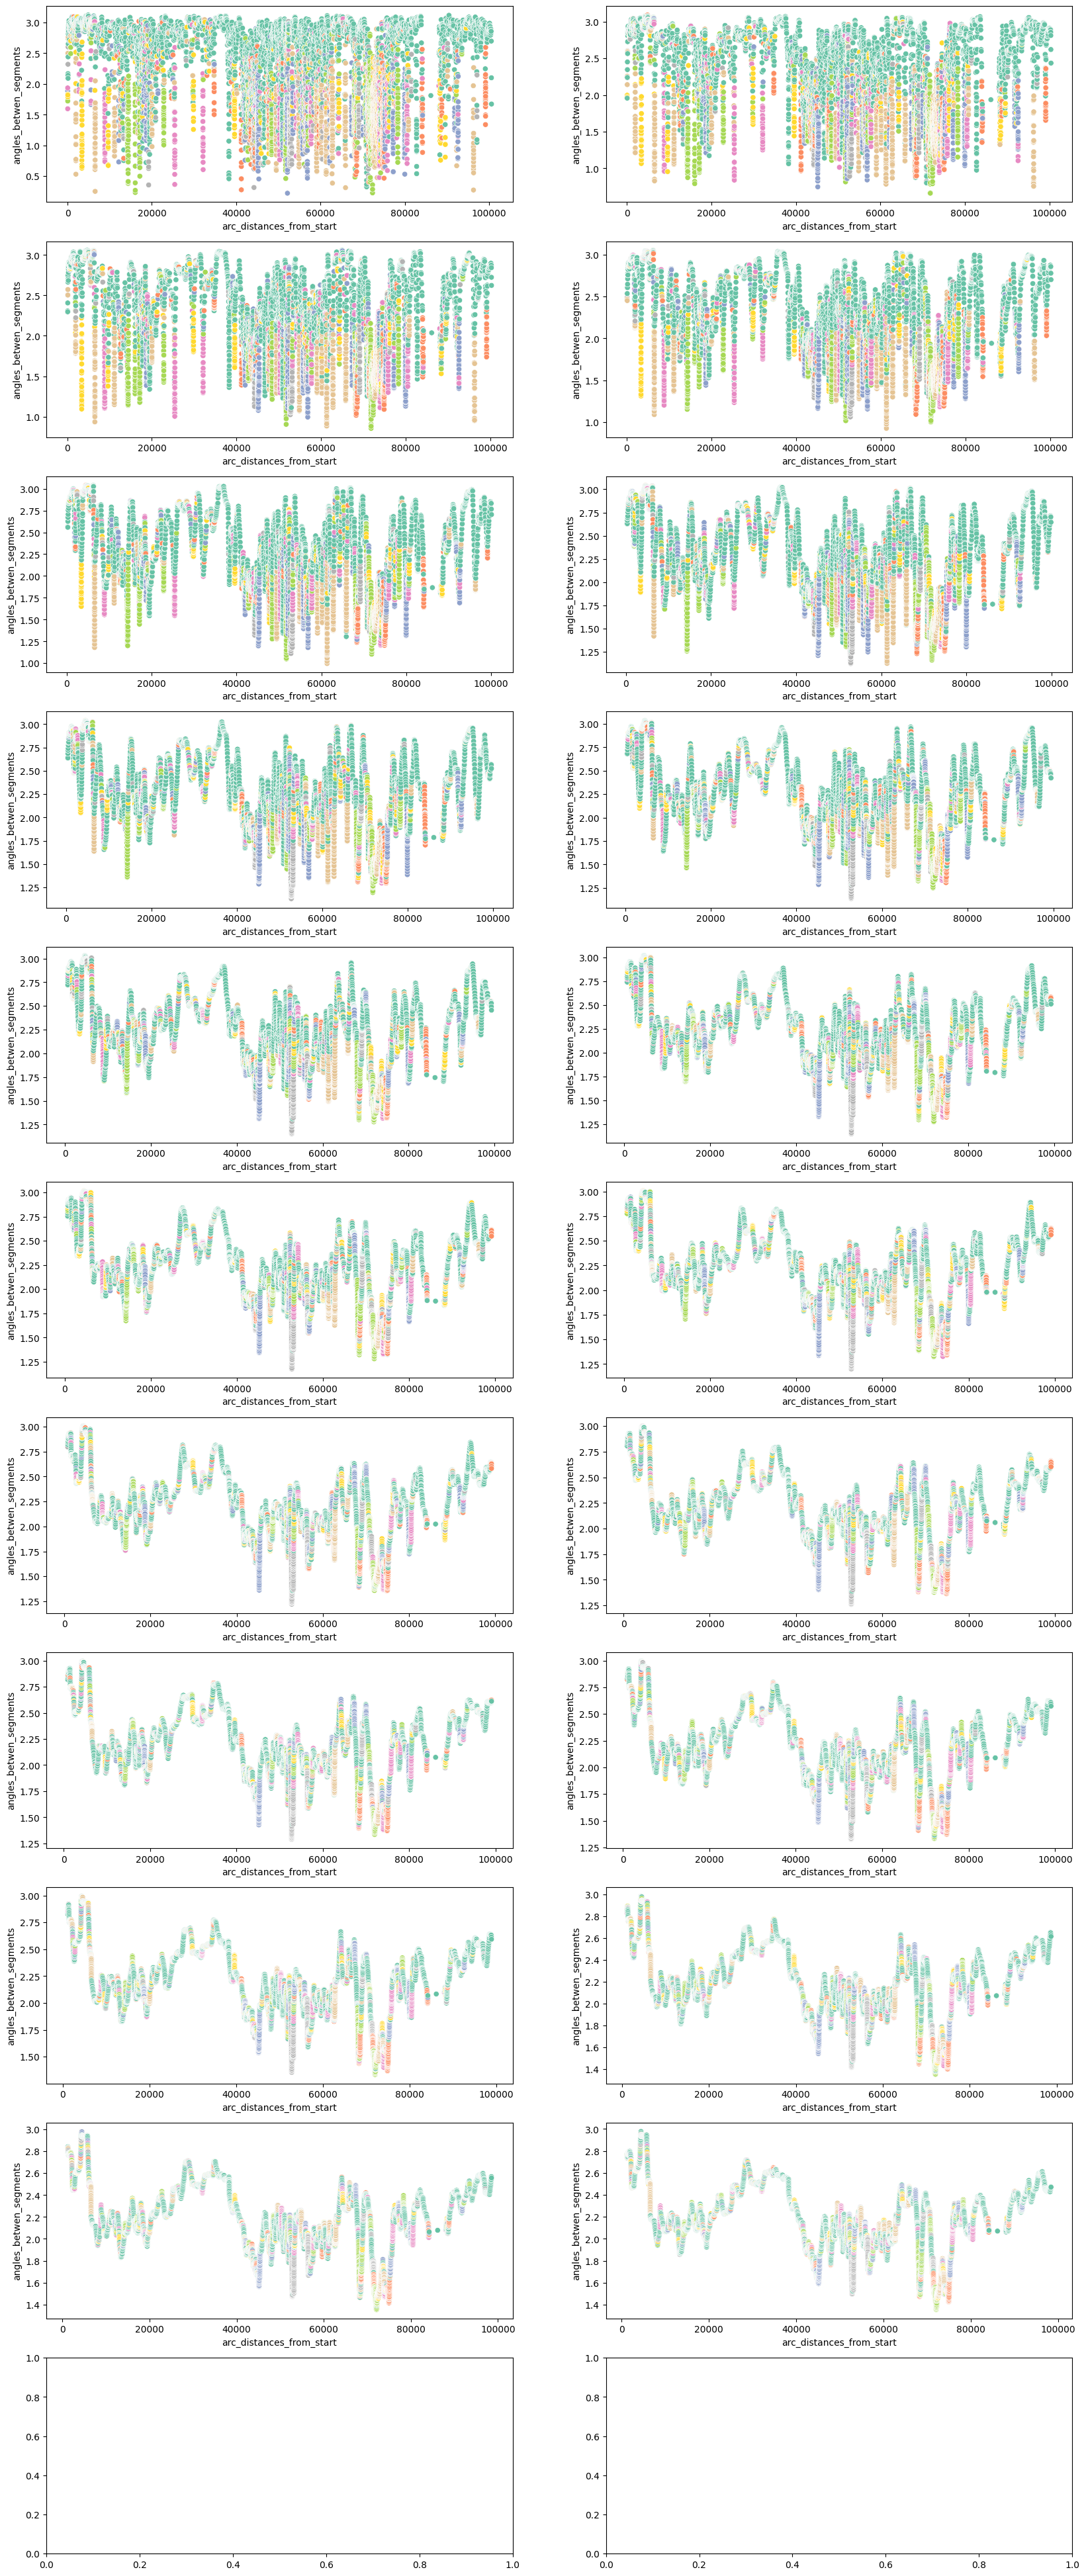

In [15]:
plot_cols = 2 # Задаём параметры сетки графиков
plot_rows = len(ns_rolling_window) // 2 + 1
fig, axs = plt.subplots(plot_rows, plot_cols, figsize=(20, 50))

for n, ax in zip(ns_rolling_window, chain(*axs)):
    rolling_window_sum = df["angles_betwen_segments"].rolling(window=n, center=True).mean()

    sns.scatterplot(
        data=df,
        x='arc_distances_from_start',
        y=rolling_window_sum,
        hue="cluster",
        ax=ax,
        palette='Set2',
        legend=None,
    )

plt.show()

In [16]:
df

lat       lon     ele                 date  sec_from_start  Target  \
0     0.750217  0.756189  1846.8  2024-06-30 04:24:05             0.0     0.0   
1     0.750218  0.756192  1849.2  2024-06-30 04:24:23            18.0     0.0   
2     0.750220  0.756194  1847.8  2024-06-30 04:24:32            27.0     0.0   
3     0.750221  0.756195  1845.4  2024-06-30 04:24:46            41.0     0.0   
4     0.750221  0.756195  1844.0  2024-06-30 04:24:58            53.0     1.0   
...        ...       ...     ...                  ...             ...     ...   
9414  0.752441  0.753038  2148.7  2024-07-08 09:11:17        708432.0     0.0   
9415  0.752439  0.753044  2154.9  2024-07-08 09:11:47        708462.0     1.0   
9416  0.752438  0.753048  2154.4  2024-07-08 09:12:17        708492.0     0.0   
9417  0.752435  0.753054  2146.8  2024-07-08 09:12:47        708522.0     0.0   
9418  0.752434  0.753055  2149.2  2024-07-08 09:13:17        708552.0     0.0   

      arc_distances_from_start  angles_betwen_segments  \
0                     0.000000                2.696647   
1                    14.550806                3.053461   
2                    25.076210                0.059298   
3                    37.346233                0.608585   
4                    39.773421                3.010950   
...                        ...                     ...   
9414             100487.034708                2.983286   
9415             100518.340461                3.046683   
9416             100540.359837                2.334636   
9417             100574.149380                0.000000   
9418             100579.240003                0.000000   

      lengths_betwen_segments  cluster  
0                2.974781e-06        0  
1                1.905517e-06       -1  
2                2.283475e-06        1  
3                4.436858e-07        2  
4                1.458540e-06        2  
...                       ...      ...  
9414             6.545466e-06       -1  
9415             4.466627e-06       -1  
9416             6.700040e-06       -1  
9417             8.081365e-07       -1  
9418             0.000000e+00       -1  

[9419 rows x 10 columns]

По этим графикам, по идее нужно как-то подобрать размер скользящего окна получше

## 3. Pairplot

Тут пока что ничего интересного

In [9]:
# sns.pairplot(data=df, hue='cluster', height=10, palette='Paired')

## 4. Удаление точек

На глаз выбираем порог для оконных сумм и удаляем целиком все кластеры, хотя бы одна точка которых оказалась ниже порога (значение оконной суммы вокруг которой оказалось ниже порога)

Как подбирается значение ```n```? Не знаю пока что))

In [10]:
best_n = 50     # Выбранная ширина скользящего окна
threashold = 1.3 # Пороговое значение оконных сумм

Добавляем оконные суммы в датафрейм

In [11]:
df['rolling_sum'] = df["angles_betwen_segments"].rolling(window=best_n, center=True).mean()

Удаляем кластеры, содержащие плохие точки

In [16]:
bad_labels = df[df['rolling_sum'] < threashold]['cluster'].values
#df['deleted'] = df['cluster'].isin(bad_labels)

clean_df = df[~df['deleted']] # Очищенный датафрейм

In [17]:
df['deleted'] = False


Превратим оставленные точки обратно в .gpx файл

In [18]:
write_to_gpx(clean_df, 'tracks/tmp/tmp.gpx')

Посмотрим, чем отличается очищенный трек от сырого

In [ ]:
# big_df = pd.concat([df, clean_df])

In [19]:
view_df(df)